In [2]:
''' Random Tree Workflow '''
#imports

import pandas as pd #Zur Arbeit mit dem Datenrahmen
import matplotlib.pyplot as plt #Plotten der Diagrammwerte
from sklearn.model_selection import train_test_split # Aufteilung des Datensatzes in Trainings und Testdaten
from sklearn.ensemble import RandomForestRegressor # RandomForest Methode 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # Bewertungsmetriken
from sklearn.preprocessing import LabelEncoder # Encoder für kategorische Variablen im Datenrahmen
import math # Für mathematische Operationen
from sklearn.linear_model import LinearRegression # Lineare Regression zum Voraussagen der Zukunftsdaten
from sklearn.model_selection import cross_val_score # Cross Validation des Trainingsdatensatzes
from sklearn.model_selection import KFold # Cross Validation des Trainingsdatensatzes

# Systemseitige Imports

import os # => Speichern der Diagramme
import pickle # => Speichern der Modelle
import multiprocessing # => Alle Systemressourcen auslasten


In [3]:
model_path = "/home/server_dummy_path/ML-Learning/models"
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [4]:
class DatasetImport:

    def __init__(self, data:str, target_index) -> None:
        
        #Initialisierung der Instanz. Direkt in der Instanzierung bereinigen wir den Datensatz
        #und bereiten ihn mithilfe des LabelEncoders für das spätere Training vor. 
        
        self.target_index = target_index
        self.dataframe = None
        self.import_data(data)
        self.subset_value = round(pow(self.dataframe.shape[1], 0.5))
        self.drop_column(0)
        self.get_dataset_columns()
        self.label_encoding(0)	
        self.label_encoding(1)
        

    
    # Random Forest Rule of Thumb:
    # Typischerweise erzielt man die optimalen Ergebnisse mit einem Random Forest, 
    # wenn die Anzahl der maximal verwendeten Features ungefähr der Quadratwurzel 
    # der insgesamt verfügbaren Features im Datensatz entspricht. 
    # Diesen Wert berechnen wir direkt im Zuge der Initialisierung der Klasse.
    
    def get_recommended_subset(self, subset_value):
        self.subset_value = subset_value
        print(f'Recommended subset size is: {subset_value}')
        return subset_value   
    
    # Import des Datensatzes
    def import_data(self, data):
        self.dataframe = pd.read_csv(f'{data}.csv')
        self.dataframe.dropna(inplace= True)
        return self.dataframe
    
    # Um Type_Errors zu vermeiden, schreiben wir die drop() Funktion um und 
    # referenzieren auf den Index statt dem Namen
    
    def drop_column(self, column_index):
         self.dataframe.drop(self.dataframe.columns[column_index], axis=1, inplace=True)
         return self.get_dataset_columns()
    
    # Gibt die zur Verfügung stehenden Spalten aus

    def get_dataset_columns(self):
        columns_list = list(self.dataframe.columns)
        print(f'Available Datapoints: {columns_list}')
        return columns_list
    
    # Gibt die Datenwerte einer Spalte aus, hier wird wieder auf den Index referenziert um Type_Errors zu vermeiden.

    def get_data_from_column(self, column_index: int):
        column_data = self.dataframe[self.dataframe.columns[column_index]]
        print(column_data)
        return column_data
    
    # Der LabelEncoder kodiert kategorische Werte (bspw. Ländernamen) in numerische Werte, da der Random Forest
    # nur mit numerischen Werten arbeiten kann. 
    
    def label_encoding(self, column_index: int):
        label_encoder = LabelEncoder()
        self.dataframe[self.dataframe.columns[column_index]] = label_encoder.fit_transform(
            self.dataframe[self.dataframe.columns[column_index]]
        )
        
    # Die Funktion `generate_test_sets` teilt das Datenset in Trainings- und Testdatensätze auf. 
    # Die Aufteilung basiert auf dem angegebenen Verhältnis `test_size`.
    # `X_train` und `y_train` sind die Trainingsdaten und -zielwerte, `X_test` und `y_test` sind die 
    # entsprechenden Testdatensätze. Die Reproduzierbarkeit der Aufteilung wird durch den optionalen
    # Parameter `random_state` ermöglicht.
    
    
    def generate_test_sets(self, test_size: float, random_state=None):
        parameter = list(self.dataframe.drop(self.dataframe.columns[self.target_index], axis=1).columns)
        X_train, X_test, y_train, y_test = train_test_split(
        self.dataframe[parameter],
        self.dataframe[self.dataframe.columns[self.target_index]],
        test_size=test_size
    )
        return X_train, X_test, y_train, y_test

    
    def generate_future_data(self, end_year):
        # Entferne alle Zeilen mit Ländercode 195 oder Energy_Type gleich 0
        # Ländercode 195 ist Welt und der Energy_type 0 beschreibt alle Energie-Typen
        df_filtered = self.dataframe[
            (self.dataframe['Country'] != 195) & 
            (self.dataframe['Energy_type'] != 0)
        ]

        # Finde den niedrigsten und höchsten Ländercode
        min_country_code = df_filtered['Country'].min()
        max_country_code = df_filtered['Country'].max()

        future_data_list = []

        target_name = self.dataframe.columns[self.target_index]

        # Durchlaufe alle Ländercodes im Bereich von min_country_code bis max_country_code
        for country_code in range(min_country_code, max_country_code + 1):
            df_country = df_filtered[df_filtered['Country'] == country_code]

            start_year = df_country['Year'].max() + 1
            future_data = pd.DataFrame({'Year': range(start_year, end_year + 1)})

            # Durchlaufe alle Features außer ausgeschlossene
            excluded_features = ['Year', 'Country', 'Energy_type', target_name]

            for feature in df_country.columns:
                if feature not in excluded_features:
                    X = df_country[['Year']]
                    y = df_country[feature]
                    model = LinearRegression()
                    model.fit(X, y)
                    predictions = model.predict(future_data[['Year']])
                    future_data[feature] = abs(predictions)

            # Füge 'Country' und 'Energy_type' Informationen zu 'future_data' hinzu
            future_data['Country'] = country_code
            # Nehme den meistgenutzten Energy_type des jeweiligen Landes, der nicht 0 ist
            future_data['Energy_type'] = df_country['Energy_type'].mode()[0]

            future_data_list.append(future_data)

        # Kombiniere alle DataFrames aus der Liste in ein einziges DataFrame
        combined_future_data = pd.concat(future_data_list, ignore_index=True)
        desired_order = ['Country', 'Energy_type', 'Year', 'Energy_consumption', 'Energy_production', 'GDP', 'Population', 'Energy_intensity_per_capita', 'Energy_intensity_by_GDP']
        combined_future_data = combined_future_data[desired_order]

        # Speichere das kombinierte DataFrame in der Klasse für zukünftige Verwendung
        self.df_future = combined_future_data
        return combined_future_data

In [ ]:
# Workflow:
# Zunächst wird ein Random Forest-Modell unter Verwendung von Kreuzvalidierung (cv) trainiert, um den durchschnittlichen
# MSE (Mean Squared Error) zu ermitteln.
# Dann werden verschiedene Modelle mit unterschiedlicher Anzahl von Estimatoren trainiert, um den optimalen Wert zu finden.
# Das beste Modell mit der niedrigsten Fehlerrate wird schließlich gespeichert.



def train_and_evaluate_cv(X_train, y_train, n_estimators, cv_folds, random_state):
    
    """
    Trainiert einen RandomForestRegressor mit Kreuzvalidierung und berechnet den durchschnittlichen negativen MSE.
    
    Parameter:
    - X_train: Trainingsdatensatz
    - y_train: Abhängige Variable
    - n_estimators: Anzahl der Bäume im Random Forest
    - cv_folds: Anzahl der Folds in der Kreuzvalidierung
    - random_state: Seed für die Zufälligkeit um Reproduzierbarkeit zu gewährleisten
    
    Rückgabe:
    - Durchschnittlicher negativer MSE über alle Kreuzvalidierungsfolds hinweg
    """
    
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)    
    clf = RandomForestRegressor(n_estimators=n_estimators, max_features=3, random_state=random_state, n_jobs=-1)    
    mse_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)    
    mse_scores = -mse_scores

    '''
    Erklärung negativer MSE:
    scikit-learn gibt den MSE bei der Kreuzvalidierung immer negativ zurück.
    '''
    
    average_mse = mse_scores.mean()
    
    return average_mse

def train_and_save_best_model(X_train, y_train, n_estimators, cv_folds=5, random_state=None):
    
    """
    Legacy Version: 
    Diese Funktion war in einer alten Codeversion wichtig, um nicht alle Variablen neu schreiben zu müssen
    befindet sie sich weiterhin im Repository.
    """
    
    best_mse = train_and_evaluate_cv(X_train, y_train, n_estimators, cv_folds, random_state)
    return best_mse

def find_optimal_estimators(X_train, y_train, X_test, y_test, start_estimators=25, end_estimators=400, step=25, 
                            cv_folds=10, chart_path="/home/server_dummy_path/ML-Learning/figures", 
                            model_path="/home/server_dummy_path/ML-Learning/models", random_state=None):
    
    
"""
    Ermittelt die optimale Anzahl von Estimatoren für den RandomForestRegressor durch Training und Evaluierung 
    von Modellen mit unterschiedlichen Estimator-Anzahlen. Die Modelle werden mittels Kreuzvalidierung bewertet 
    und zusätzlich auf einem separaten Testdatensatz getestet. Ein Modell wird nur dann gespeichert und für 
    das Plotten markiert, wenn es auf dem Testdatensatz besser abschneidet als bei der Kreuzvalidierung.

    Parameter:
    - X_train: Die zur Verfügung stehenden Trainingsdaten.
    - y_train: Die zugehörigen Trainingszielwerte.
    - X_test: Die zur Verfügung stehenden Testdaten.
    - y_test: Die zugehörigen Testzielwerte.
    - start_estimators, end_estimators, step: Definieren einen Bereich und eine Schrittgröße für die Anzahl 
      der bei den Random-Forest-Modellen zu testenden Bäume (Estimatoren).
    - cv_folds: Die Anzahl der Durchführungen der Kreuzvalidierung.
    - chart_path: Der Speicherpfad für Diagramme, die die Modellleistung visualisieren.
    - model_path: Der Speicherpfad für das beste Random-Forest-Modell.
    - random_state: Ein Seed-Wert, um reproduzierbare Ergebnisse zu gewährleisten.

    Rückgabe:
    - Ein Dictionary, das die Anzahl von Estimatoren auf den besten Kreuzvalidierungs-MSE abbildet.
    - Ein weiteres Dictionary, das die Anzahl von Estimatoren auf den MSE des Testdatensatzes abbildet.
    """
    
    best_mse_per_estimator = {}
    test_mse_per_estimator = {}
    plot_flag = False  # Hinzugefügte boolesche Variable, um zu bestimmen, ob geplottet werden soll
    best_model = None
    best_mse = float('inf')
    best_cv_mse = float('inf')
    best_n_estimators = 0
    best_r2 = 0
    best_mae = float('inf')
    
    for n_estimators in range(start_estimators, end_estimators + 1, step):
        print(f"Training mit {n_estimators} Estimatoren...")
        cv_mse = train_and_save_best_model(X_train, y_train, n_estimators, cv_folds, random_state)
        best_mse_per_estimator[n_estimators] = cv_mse

        # Berechne den Test-MSE für das aktuelle Modell
        test_mse, test_r2, test_mae = evaluate_on_test_data(X_train, y_train, X_test, y_test, n_estimators, random_state)
        test_mse_per_estimator[n_estimators] = test_mse

        if cv_mse < best_cv_mse: # Aktualisieren des besten CV-MSEs falls nötig
            best_cv_mse = cv_mse
            
        if test_mse < cv_mse:
            if test_mse < best_mse:  # Vergleich des Test-MSE
                best_mse = test_mse
                best_r2 = test_r2  # Speichern des R^2-Wertes des besten Modells
                best_mae = test_mae  # Speichern des MAE des besten Modells
                best_n_estimators = n_estimators
                best_model = RandomForestRegressor(n_estimators=best_n_estimators, max_features=int(math.sqrt(X_train.shape[1])), random_state=random_state, n_jobs=-1)
                best_model.fit(X_train, y_train)
                plot_flag = True  # Setzen des Flags für das Plotten

    # Speichern des besten Modells
    if best_model is not None:
        if plot_flag:
            with open(f"{model_path}/best_model_estimators_{best_n_estimators}_rs{str(random_state)}.pkl", "wb") as f:
                pickle.dump(best_model, f)
            print(f"Das beste Modell mit {best_n_estimators} Estimatoren wurde als Pickle-Datei gespeichert.")

    # Ruft die Plot-Funktionen auf, wenn plot_flag gesetzt ist, nachdem alle Iterationen beendet wurden
    if plot_flag:
        plot_cv_performance(best_mse_per_estimator, start_estimators, end_estimators, chart_path, random_state)
        plot_test_performance(test_mse_per_estimator, best_mae, best_r2, start_estimators, end_estimators, chart_path, random_state)

    return best_mse_per_estimator, test_mse_per_estimator

def evaluate_on_test_data(X_train, y_train, X_test, y_test, n_estimators, random_state=None):
    
    """
    Trainiert einen RandomForestRegressor und bewertet ihn anhand von Testdaten.

    Argumente:
        X_train: Trainingsdatensatz.
        y_train: Zielwerte des Trainingsdatensatzes.
        X_test: Testdatensatz zur Evaluation.
        y_test: Zielwerte des Testdatensatzes.
        n_estimators: Anzahl der Entscheidungsbäume im RandomForestRegressor.
        random_state: Parameter zur Generierung von reproduzierbaren Ergebnissen.

    Gibt zurück:
        test_mse: Mean Squared Error des Modells auf dem Testdatensatz.
        test_r2: R-squared-Wert, der angibt, wie gut die vorhergesagten Werte mit den tatsächlichen Zielwerten übereinstimmen.
        test_mae: Mean Absolute Error des Modells auf dem Testdatensatz.
    """
    
    
    clf = RandomForestRegressor(n_estimators=n_estimators, max_features=int(math.sqrt(X_train.shape[1])), random_state=random_state, n_jobs=-1)
    clf.fit(X_train, y_train)

    predictions = clf.predict(X_test)
    test_mse = mean_squared_error(y_test, predictions)
    test_r2 = r2_score(y_test, predictions)
    test_mae = mean_absolute_error(y_test, predictions)

    return test_mse, test_r2, test_mae

In [6]:
# Logik für den Plot der Diagramme

def plot_cv_performance(best_mse_per_estimator, start_estimators, end_estimators, chart_path, random_state):
    plt.figure(figsize=(10, 8))  # Größe des Plots anpassen
    plt.plot(list(best_mse_per_estimator.keys()), list(best_mse_per_estimator.values()), marker='o', color='blue', 
             label='CV MSE')

    plt.xlabel('Anzahl der Estimatoren')
    plt.ylabel('MSE')
    plt.title('CV MSE für verschiedene Anzahlen von Estimatoren')

    # Finde den niedrigsten MSE-Wert sowie die entsprechende Anzahl von Estimatoren
    min_cv_mse = min(best_mse_per_estimator.values())
    min_cv_estimators = min(best_mse_per_estimator, key=best_mse_per_estimator.get)
    
    # Bestimmen der Grenze für die Y-Achse um dynamische Limits zu ermöglichen
    ymin, ymax = plt.ylim() 
    offset = (ymax - ymin) * 0.15 #Pfeil verschieben
    
    # Erstelle das Textfeld und den dünnen Pfeil
    plt.annotate(
        f'Min CV MSE: {round(min_cv_mse, 2)}',
        xy=(min_cv_estimators, min_cv_mse),  # Position des niedrigsten CV MSE herausfinden
        xytext=(min_cv_estimators, min_cv_mse + offset),  # Dynamische Verschiebung oberhalb des niedrigsten Punktes
        textcoords='data',
        arrowprops=dict(facecolor='blue', width=0.5, headwidth=5, shrink=0.05),  # Stil des Pfeils
        horizontalalignment='center',  # Zentriere den Text horizontal über dem Pfeil
        verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.5", alpha=0.5, color='blue')  # Fügt dem Textfeld die Umrandung hinzu
    )

    plt.tight_layout()
    plt.legend()
    #Die Bilder die folgend gespeichert werden, haben wir unten angefügt in Anhang 1
    plt.savefig(f"{chart_path}/cv_mse_versus_estimators{start_estimators}_{end_estimators}_rs{str(random_state)}.png")
    plt.close()

def plot_test_performance(test_mse_per_estimator, best_mae, best_r2, start_estimators, end_estimators, chart_path, 
                          random_state):
    
    plt.figure(figsize=(10, 8))
    plt.plot(list(test_mse_per_estimator.keys()), list(test_mse_per_estimator.values()), marker='x', linestyle='--', color='green', label='Test MSE')

    plt.xlabel('Anzahl der Estimatoren')
    plt.ylabel('MSE')
    plt.title('Test MSE für verschiedene Anzahlen von Estimatoren')

    # Finde den niedrigsten MSE-Wert sowie die entsprechende Anzahl von Estimatoren
    min_test_mse = min(test_mse_per_estimator.values())
    min_test_estimators = min(test_mse_per_estimator, key=test_mse_per_estimator.get)

    # Text für MAE und R^2-Werte erstellen, die im Diagramm angezeigt werden
    text_str = (f'Min Test MSE: {round(min_test_mse, 4)}\n'
                f'Best MAE: {round(best_mae, 4)}\n'
                f'Best R^2: {round(best_r2, 4)}\n'
                'Test size: 20 %')

    # Positioniere den Text in der Mitte oben im Diagramm
    plt.gca().text(0.5, 0.85, text_str, fontsize=12, ha='center', va='top', transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Zeichne die Legende, ohne dass sie die Textbox überlappt
    plt.legend(loc='upper right')

    ymin, ymax = plt.ylim()  # Aktuellen y-Achsenbereich abrufen
    y_offset = (ymax - ymin) * 0.15

    plt.annotate(
        f'Min Test MSE: {round(min_test_mse, 2)}',
        xy=(min_test_estimators, min_test_mse),  # Position des niedrigsten Test MSE
        xytext=(min_test_estimators, min_test_mse + y_offset),  # Dynamische Verschiebung oberhalb des niedrigsten Punktes
        textcoords='data',
        arrowprops=dict(facecolor='black', width=0.5, headwidth=5, shrink=0.05),  # Stil des Pfeils
        horizontalalignment='center',  # Zentriert den Text horizontal um den Pfeil
        verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.5", alpha=0.5, color='green')
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Verhindere das Abschneiden von Titeln oder Legenden
    plt.savefig(f"{chart_path}/test_mse_versus_estimators{start_estimators}_{end_estimators}_rs{str(random_state)}.png")
    plt.close()


In [ ]:
#Der Funktionsaufruf

if __name__ == '__main__':
    dataset = DatasetImport('energy', 9)
    for i in range(12):
        X_train, X_test, y_train, y_test = dataset.generate_test_sets(test_size=0.2, random_state=i)
        optimal_estimators_mse, test_mse_per_estimator = find_optimal_estimators(X_train, y_train, X_test, y_test, start_estimators=25, end_estimators=400, step=25, cv_folds=10, random_state=i)
        print("Optimal Estimators MSE:")
        print(optimal_estimators_mse)
        print("\nTest MSE per Estimator:")
        print(test_mse_per_estimator)


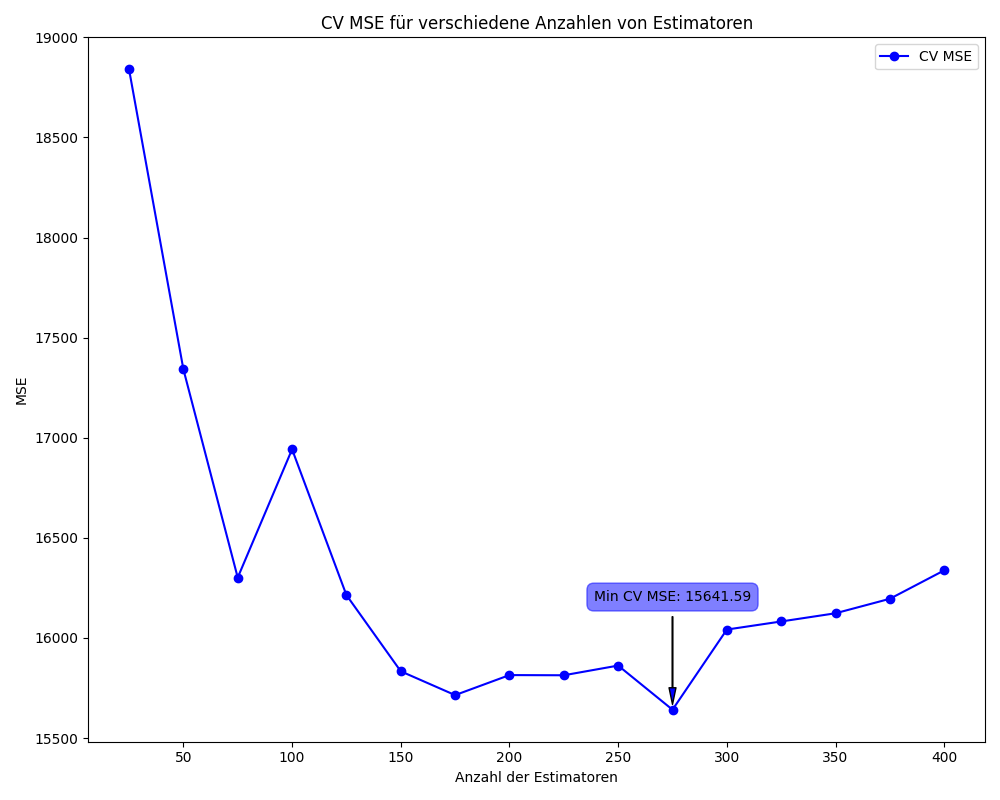

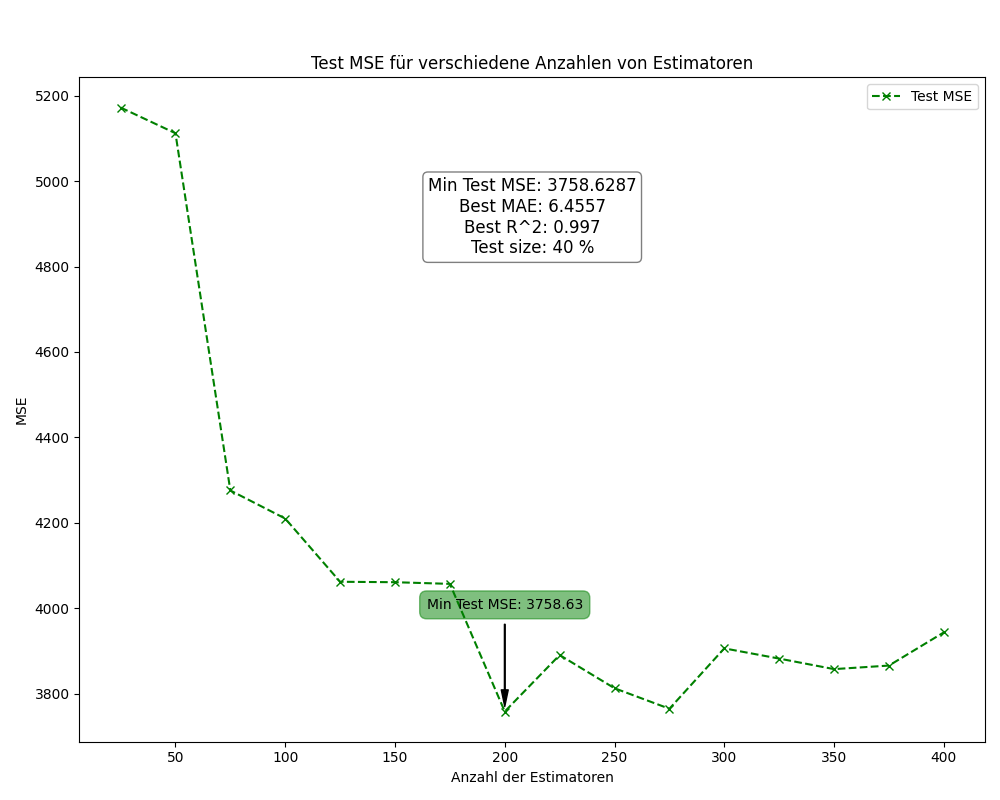

In [1]:
#Hier ist der Anhang 1
from IPython.display import Image
from IPython.display import display
x = Image(filename='figures_2/Test40_RS_11/cv_mse_versus_test_size4_estimators25_400_rs11.png')
y = Image(filename='figures_2/Test40_RS_11/test_mse_versus_test_size4_estimators25_400_rs11.png')
display(x, y)
#Das sind die Metriken für Trainingsgröße = 60 %, Features = 3, Estimatoren/Anzahl Bäume variieren bis 400
#Der Random_State = 11, für Kreuzvalidierung: k=10

In [2]:
'''
Interpretation der oberen beiden Metriken: Vielversprechendes Modell, da:
1. Für das Trainingsmodell:
    - Der MSE sinkt mit steigender Anzahl an Entscheidungsbäumen --> wird erwartet, da das Modell für eine höhere Anzahl
    an Bäumen robuster reagieren sollte.
    - Der MSE steigt ab einem bestimmten Punkt wieder an --> Der MSE hat ein Minimum, deswegen vermuten wir, dass das Modell
    die Trainingsdaten nicht einfach "auswendig" lernt
2. Für das Testmodell:
    - Das Testmodell scheint zu generalisieren, da der MSE kontinuierlich geringer ist als beim Trainingsdatenset.
    Das bedeutet, dass das Modell auf bisher unbekannte Daten mit einem geringeren durschnittlichen Fehler reagiert als im Trainingsmodell
    - Ein weiterer Indikator für die Güte unseres Modells stellt der R^2 Wert dar. Das Modell erklärt 99,7 % der Varianz.
    Der Wert gibt zwar zu bedenken, da ein so hoher Wert selten ist, und auf Overfitting hinweisen könnte, 
    allerdings hängen die Eingangsvariablen kausal mit den CO2 Emissionen der Länder zusammen, weshalb wir vermuten,
    dass diese Hohe Korrelationen begründet ist.

Fazit: Das Modell scheint zu generalisieren, endgültig wird dies aber erst mit der Plausibilität der Vorhersage der CO2-
Emissionen belegt. Aus diesem Grund erzeugen wir weitere Modelle, um dann bei der Vorhersage das passendste Modell wählen zu können.
    
'''

'\nInterpretation der oberen beiden Metriken: Vielversprechendes Modell, da:\n1. Für das Trainingsmodell:\n    - Der MSE sinkt mit steigender Anzahl an Entscheidungsbäumen --> wird erwartet, da das Modell für eine höhere Anzahl\n    an Bäumen robuster reagieren sollte.\n    - Der MSE steigt ab einem bestimmten Punkt wieder an --> Der MSE hat ein Minimum, deswegen vermuten wir, dass das Modell\n    die Trainingsdaten nicht einfach "auswendig" lernt\n2. Für das Testmodell:\n    - Das Testmodell scheint zu generalisieren, da der MSE kontinuierlich geringer ist als beim Trainingsdatenset.\n    Das bedeutet, dass das Modell auf bisher unbekannte Daten mit einem geringeren durschnittlichen Fehler reagiert als im Trainingsmodell\n    - Ein weiterer Indikator für die Güte unseres Modells stellt der R^2 Wert dar. Das Modell erklärt 99,7 % der Varianz.\n    Der Wert gibt zwar zu bedenken, da ein so hoher Wert selten ist, und auf Overfitting hinweisen könnte, \n    allerdings hängen die Eingangsv

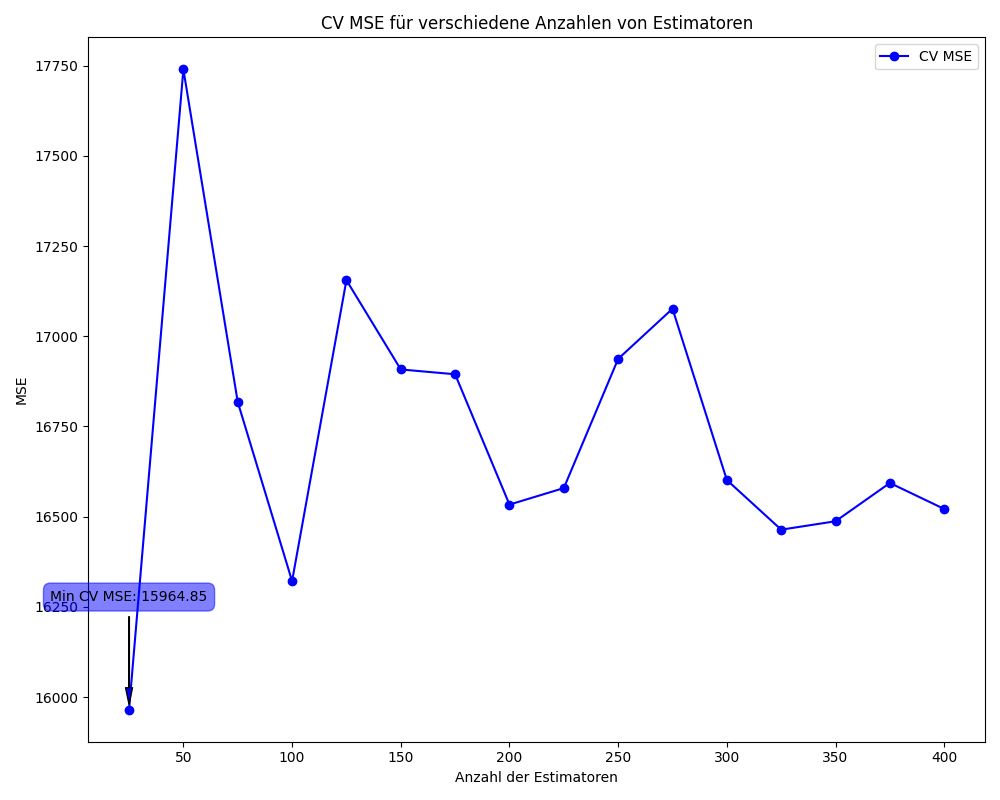

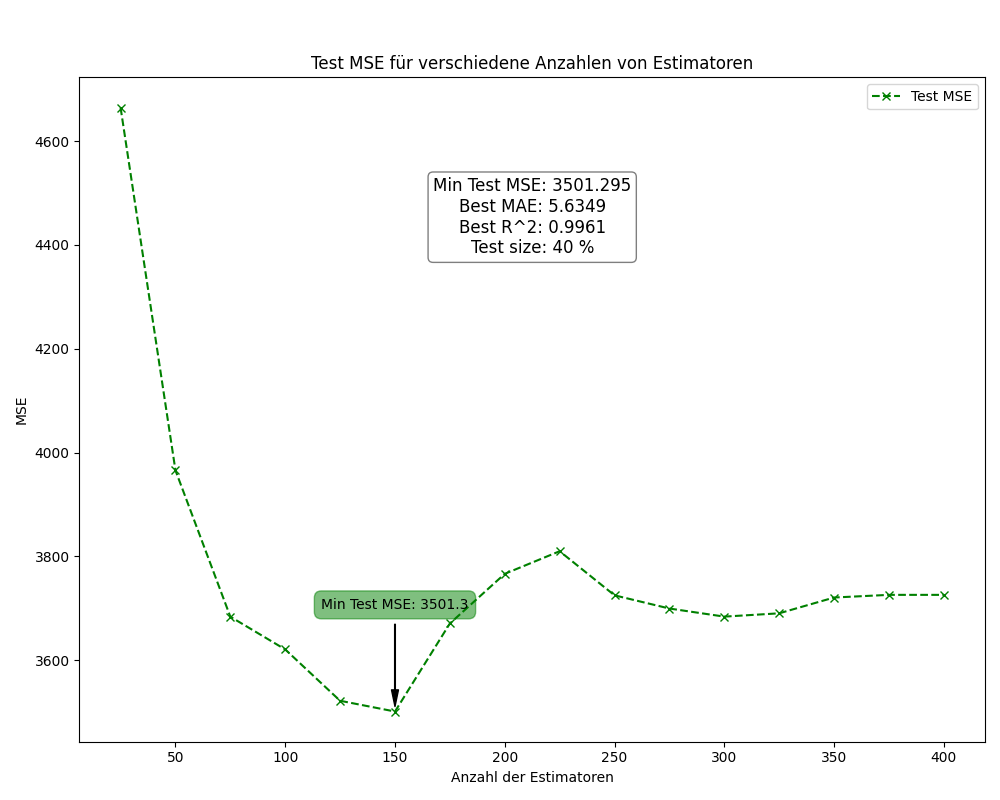

In [3]:
#Wir befinden uns immer noch in Anhang 1
from IPython.display import Image
from IPython.display import display
x = Image(filename='figures_2/Test40_RS_5/cv_mse_versus_test_size4_estimators25_400_rs5.png')
y = Image(filename='figures_2/Test40_RS_5/test_mse_versus_test_size4_estimators25_400_rs5.png')
display(x, y)
#Das sind die Metriken für Trainingsgröße = 60 %, Features = 3, Estimatoren/Anzahl Bäume variieren bis 400
#Der Random_State = 5, für Kreuzvalidierung: k=10

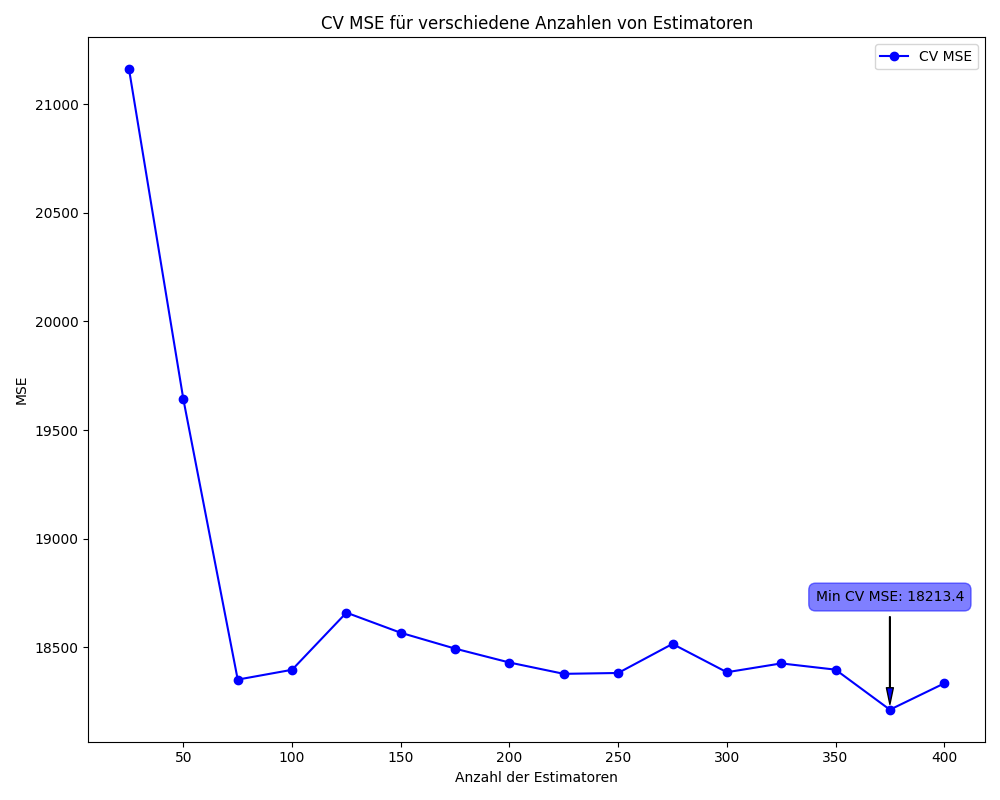

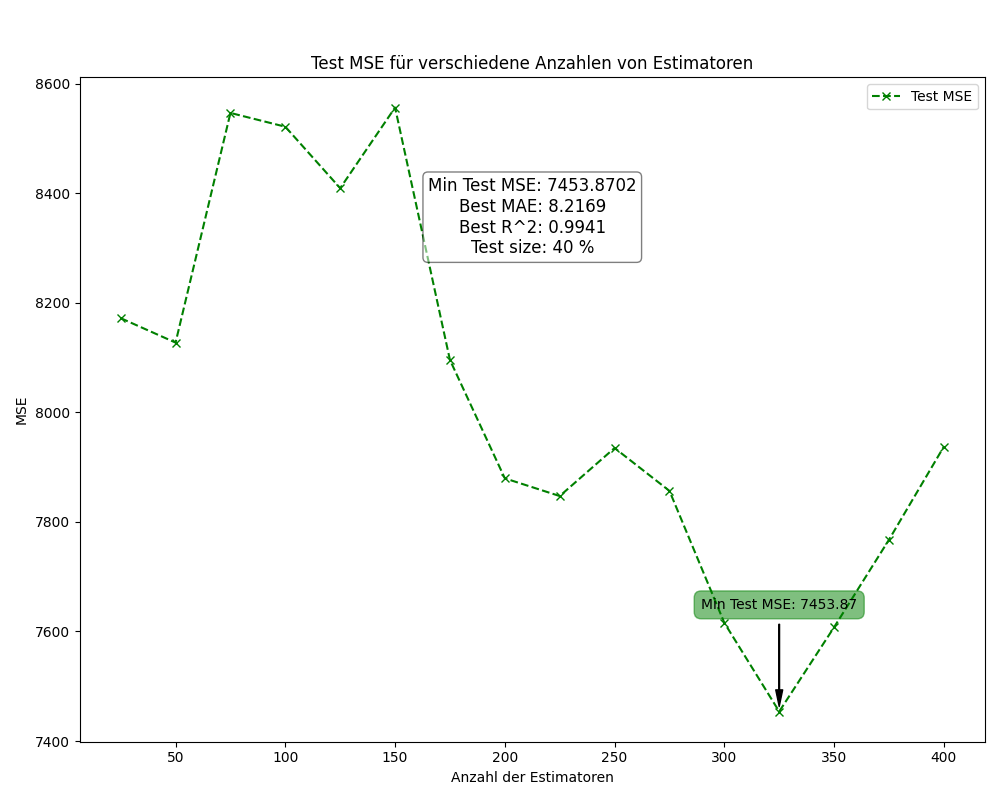

In [4]:
#Wir befinden uns immer noch in Anhang 1
from IPython.display import Image
from IPython.display import display
x = Image(filename='figures_2/Test40_RS1/cv_mse_versus_test_size4_estimators25_400_rs1.png')
y = Image(filename='figures_2/Test40_RS1/test_mse_versus_test_size4_estimators25_400_rs1.png')
display(x, y)
#Das sind die Metriken für Trainingsgröße = 60 %, Features = 3, Estimatoren/Anzahl Bäume variieren bis 400
#Der Random_State = 1, für Kreuzvalidierung: k=10

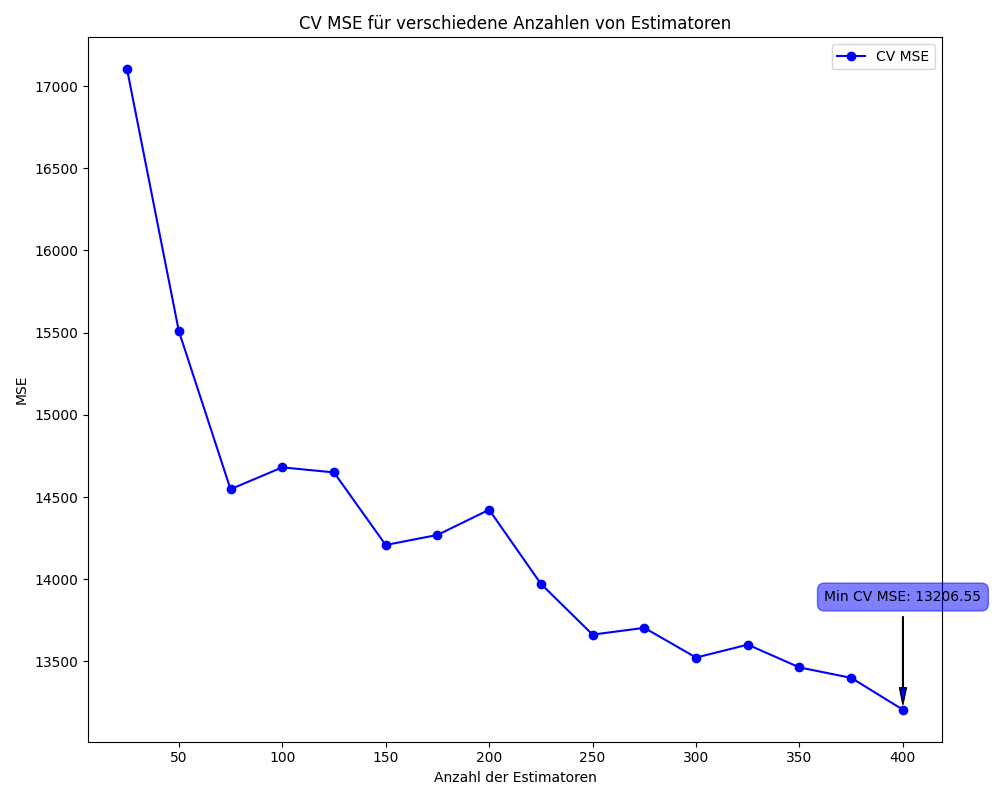

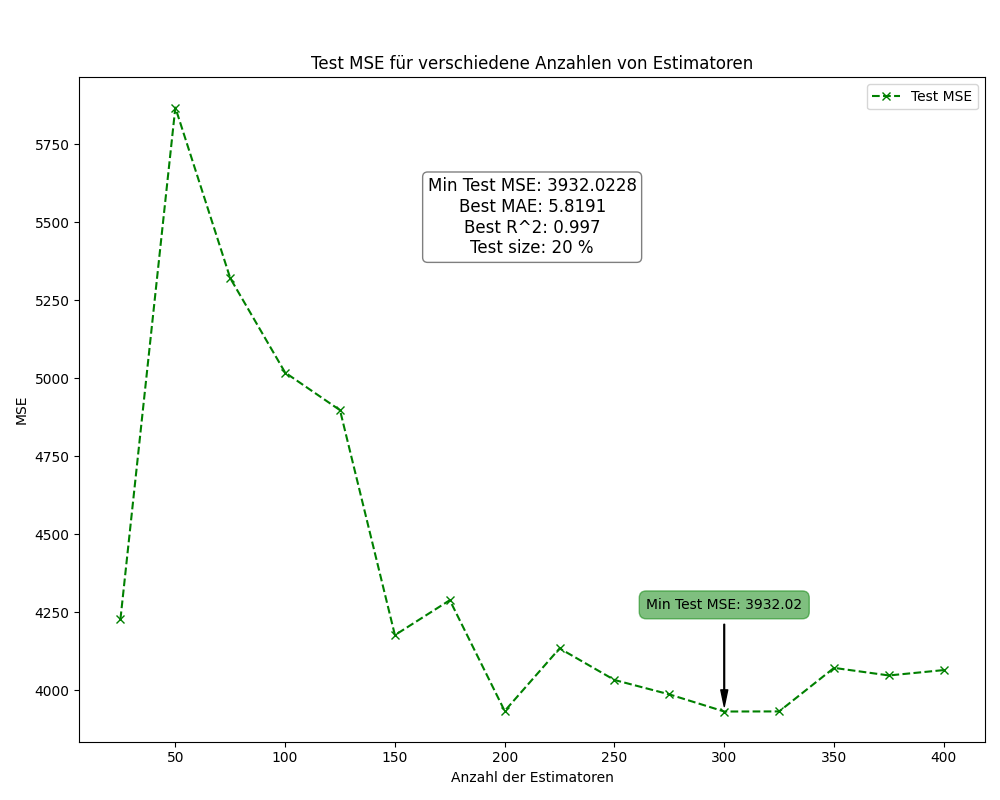

In [5]:
#Wir befinden uns immer noch in Anhang 1, Hier: Andere Trainingsgröße!
#Ziel: Optimale Trainingsdatengröße für unseren Datensatz finden
from IPython.display import Image
from IPython.display import display
x = Image(filename='figures_2/RS8/cv_mse_versus_estimators25_400_rs8.png')
y = Image(filename='figures_2/RS8/test_mse_versus_estimators25_400_rs8.png')
display(x, y)
#Das sind die Metriken für Trainingsgröße = 80 %, Features = 3, Estimatoren/Anzahl Bäume variieren bis 400
#Der Random_State = 1, für Kreuzvalidierung: k=10

In [6]:
'''
Interpretation: Im Grunde gilt hier die selbe Argumentation wie in den oberen Diagrammen, allerdings
lässt der stetig sinkende MSE im Traingsmodell darauf schließen, dass hier eventuell ein Overfit vorliegen könnte.

Fazit: Training mit 60 % der Datensätze ergab bessere Ergebnisse als 80 %.
'''

'\nInterpretation: Im Grunde gilt hier die selbe Argumentation wie in den oberen Diagrammen, allerdings\nlässt der stetig sinkende MSE im Traingsmodell darauf schließen, dass hier eventuell ein Overfit vorliegen könnte.\n\nFazit: Training mit 60 % der Datensätze ergab bessere Ergebnisse als 80 %.\n'

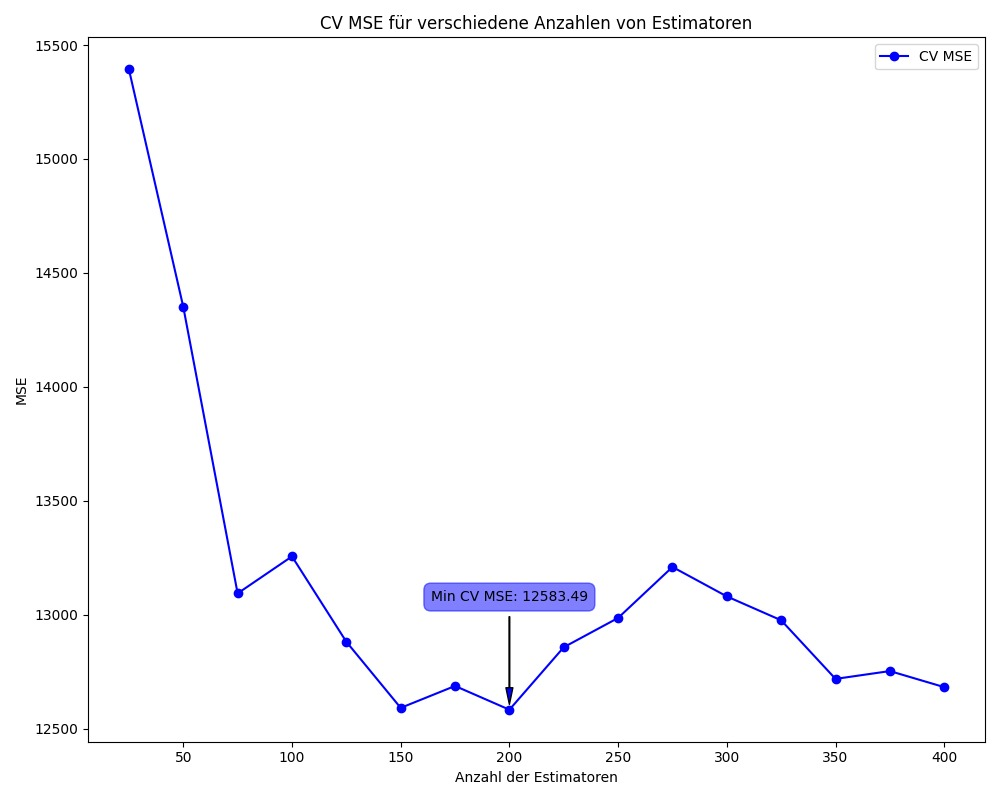

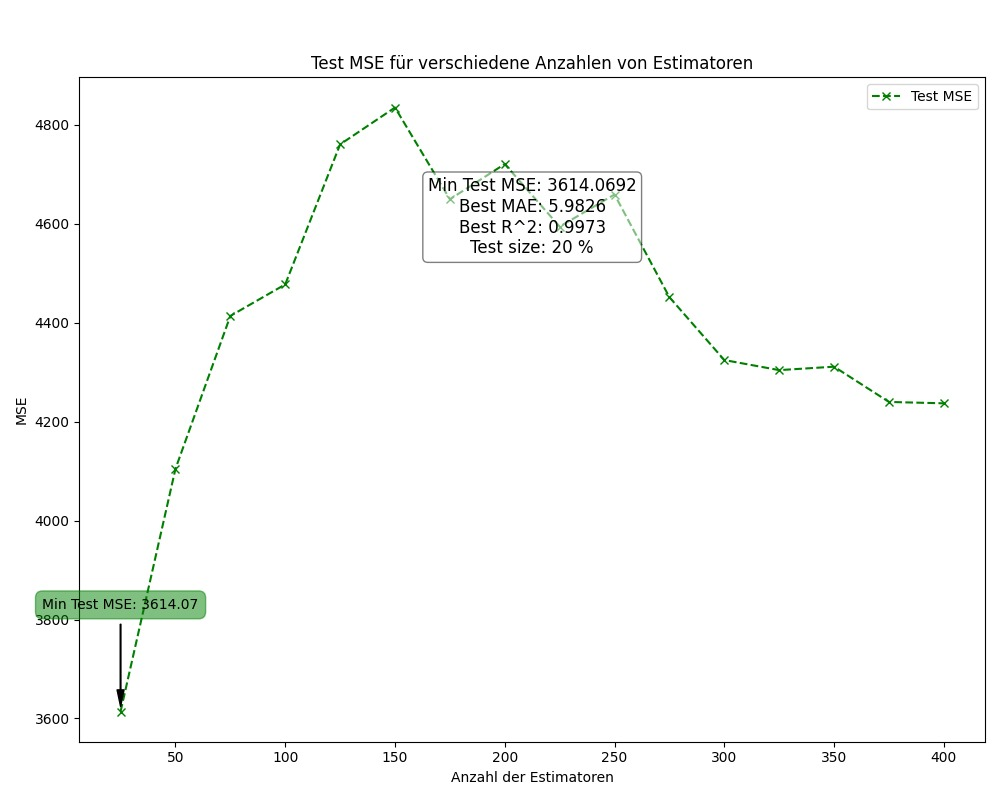

In [7]:
#Wir befinden uns immer noch in Anhang 1, Hier: Andere Trainingsgröße!
#Ziel: Optimale Trainingsdatengröße für unseren Datensatz finden
from IPython.display import Image
from IPython.display import display
x = Image(filename='figures_2/BeispielOverfitAusVorherigemTraining.jpg')
y = Image(filename='figures_2/BeispielOverfitAusVorherigemTraining2.jpg')
display(x, y)
#Das sind die Metriken für Trainingsgröße = 80 %, Features = 3, Estimatoren/Anzahl Bäume variieren bis 400
#Der Random_State = 1, für Kreuzvalidierung: k=10

In [8]:
'''
Im Trainingsmodell geht der MSE nach unten, während der MSE im Testmodell ansteigt.
Das ist nicht erwartet, da mit steigender Baumanzahl das Modell robuster werden und damit einen geringeren MSE aufweisen sollte.
Der Test MSE ist zwar klein, allerdings lässt uns die Divergenz der beiden Modelle darauf schließen, dass das Trainings-
modell die Daten auswendig gelernt hat und hier vermutlich ein Overfit vorliegt.
'''

'\nIm Trainingsmodell geht der MSE nach unten, während der MSE im Testmodell ansteigt.\nDas ist nicht erwartet, da mit steigender Baumanzahl das Modell robuster werden und damit einen geringeren MSE aufweisen sollte.\nDer Test MSE ist zwar klein, allerdings lässt uns die Divergenz der beiden Modelle darauf schließen, dass das Trainings-\nmodell die Daten auswendig gelernt hat und hier vermutlich ein Overfit vorliegt.\n'